# AI vs Human Art ML Project
### Step 1: Data Loading

We still need to check if this is the correct way to load the data..(we can ask professor if this is correct)
Also you need to load the data from your own machine after you download it(having it on git is not good apparently)


In [15]:
# import all the required packages
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
import random
import cv2
import os

import numpy as np

In [27]:

labels = ['AI_GENERATED', 'NON_AI_GENERATED']
img_size = 224
batch_size = 32

def get_file_paths(data_dir):
    """Get all file paths and labels without loading images"""
    file_paths = []
    file_labels = []

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)

        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            file_paths.append(img_path)
            file_labels.append(class_num)

    return file_paths, file_labels

def data_generator(file_paths, file_labels, batch_size=32, shuffle=True):
    """Generator that yields batches of images and labels"""
    indices = np.arange(len(file_paths))

    while True:  # Loop forever for Keras
        if shuffle:
            np.random.shuffle(indices)

        for start_idx in range(0, len(file_paths), batch_size):
            batch_indices = indices[start_idx:start_idx + batch_size]

            batch_images = []
            batch_labels = []

            for idx in batch_indices:
                try:
                    img_arr = cv2.imread(file_paths[idx])[...,::-1]  # BGR to RGB
                    if img_arr is None:
                        continue
                    resized_arr = cv2.resize(img_arr, (img_size, img_size))
                    normalized = resized_arr.astype(np.float32) / 255.0

                    batch_images.append(normalized)
                    batch_labels.append(file_labels[idx])
                except Exception as e:
                    print(f"Error loading {file_paths[idx]}: {e}")
                    continue

            if len(batch_images) > 0:
                yield np.array(batch_images), np.array(batch_labels)

def get_test_file_paths(data_dir):
    """Get all test file paths without loading images"""
    file_paths = []

    for img in os.listdir(data_dir):
        img_path = os.path.join(data_dir, img)
        if os.path.isfile(img_path):
            file_paths.append(img_path)

    return file_paths

def test_data_generator(file_paths, batch_size=32):
    """Generator for test data without labels"""
    for start_idx in range(0, len(file_paths), batch_size):
        batch_paths = file_paths[start_idx:start_idx + batch_size]
        batch_images = []

        for img_path in batch_paths:
            try:
                img_arr = cv2.imread(img_path)[...,::-1]  # BGR to RGB
                if img_arr is None:
                    continue
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                normalized = resized_arr.astype(np.float32) / 255.0
                batch_images.append(normalized)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
                continue

        if len(batch_images) > 0:
            yield np.array(batch_images)

In [29]:
train_paths, train_labels = get_file_paths('data/train')
print(f"Total training images: {len(train_paths)}")

# Get test file paths
test_paths = get_test_file_paths('data/test')
print(f"Test samples: {len(test_paths)}")
train_gen = data_generator(train_paths, train_labels, batch_size=batch_size, shuffle=True)
test_gen = test_data_generator(test_paths, batch_size=batch_size)


Total training images: 18618
Test samples: 43442


# Step 2: Visualize the data

<Axes: ylabel='count'>

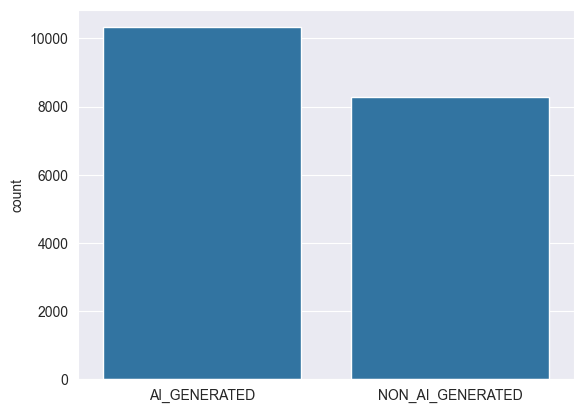

In [30]:
l = []
for label in train_labels:
    if(label == 0):
        l.append("AI_GENERATED")
    else:
        l.append("NON_AI_GENERATED")
sns.set_style('darkgrid')
sns.countplot(x=l)

Imbalanced data :(

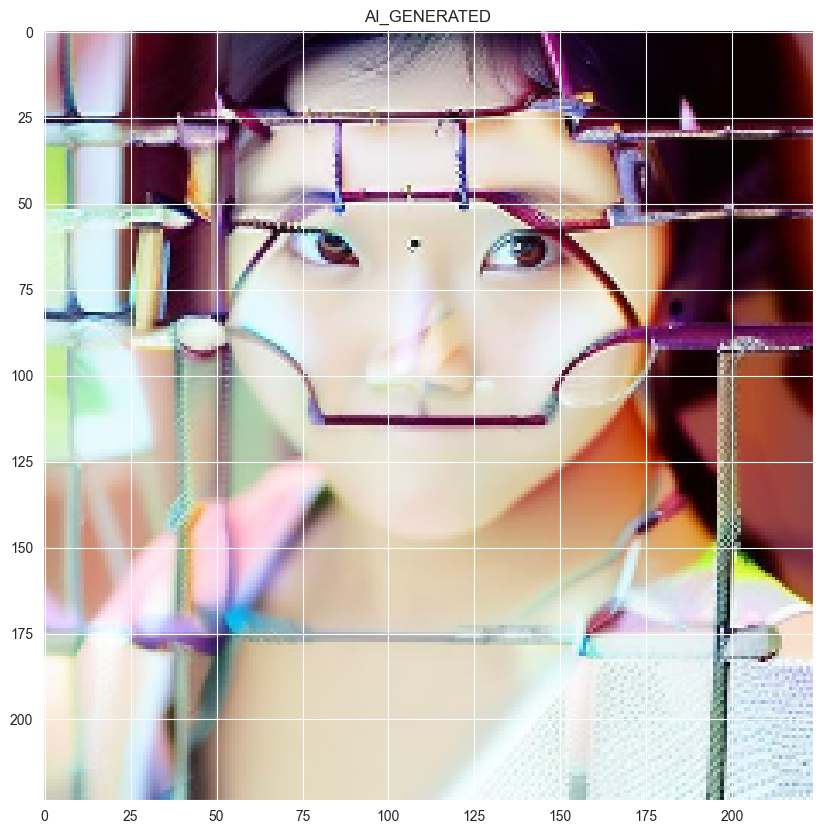

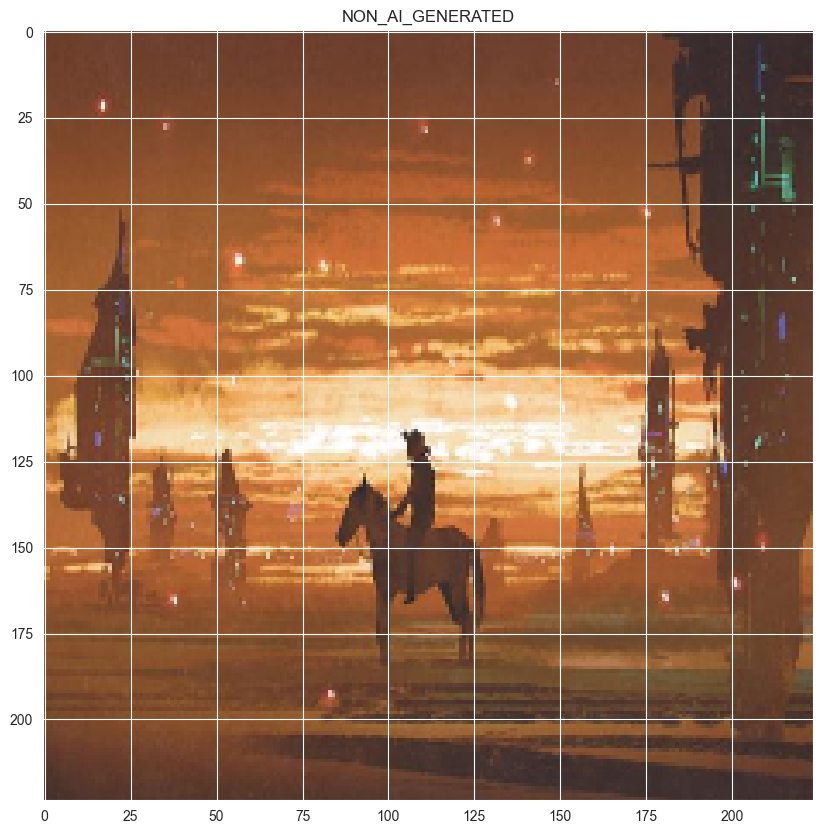

In [61]:
import random

# Get one random AI image
ai_indices = [i for i, label in enumerate(train_labels) if label == 0]
ai_idx = random.choice(ai_indices)

img_ai = cv2.imread(train_paths[ai_idx])[...,::-1]
img_ai = cv2.resize(img_ai, (img_size, img_size))

# Display AI image
plt.figure(figsize=(10, 10))
plt.imshow(img_ai)
plt.title(labels[0])
plt.show()

# Get one random Real image
real_indices = [i for i, label in enumerate(train_labels) if label == 1]
real_idx = random.choice(real_indices)

img_real = cv2.imread(train_paths[real_idx])[...,::-1]
img_real = cv2.resize(img_real, (img_size, img_size))

# Display Real image
plt.figure(figsize=(10, 10))
plt.imshow(img_real)
plt.title(labels[1])

plt.show()

Total AI Generated images: 10330
Total Non-AI Generated images: 8288


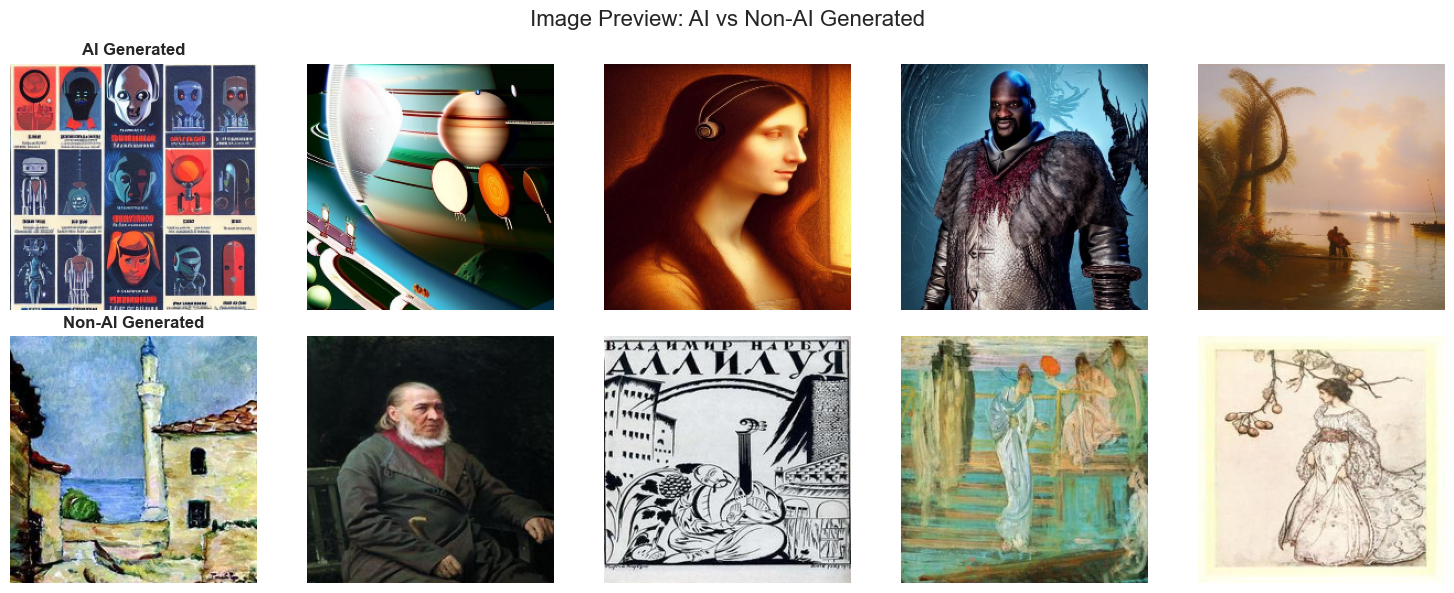

In [62]:
import random
import cv2
import matplotlib.pyplot as plt

def preview_images(file_paths, file_labels, num_images=5):
    """Preview random images from both classes"""

    # Separate indices by class
    ai_indices = [i for i, label in enumerate(file_labels) if label == 0]  # AI_GENERATED
    real_indices = [i for i, label in enumerate(file_labels) if label == 1]  # NON_AI_GENERATED

    print(f"Total AI Generated images: {len(ai_indices)}")
    print(f"Total Non-AI Generated images: {len(real_indices)}")

    # Sample random indices
    ai_sample_indices = random.sample(ai_indices, min(num_images, len(ai_indices)))
    real_sample_indices = random.sample(real_indices, min(num_images, len(real_indices)))

    # Create subplots
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
    fig.suptitle('Image Preview: AI vs Non-AI Generated', fontsize=16)

    # Load and plot AI generated images
    for i, idx in enumerate(ai_sample_indices):
        img = cv2.imread(file_paths[idx])[...,::-1]  # BGR to RGB
        img = cv2.resize(img, (img_size, img_size))
        axes[0, i].imshow(img)
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('AI Generated', fontsize=12, fontweight='bold')

    # Load and plot Non-AI generated images
    for i, idx in enumerate(real_sample_indices):
        img = cv2.imread(file_paths[idx])[...,::-1]  # BGR to RGB
        img = cv2.resize(img, (img_size, img_size))
        axes[1, i].imshow(img)
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Non-AI Generated', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Preview 5 images from each class
preview_images(train_paths, train_labels, num_images=5)

# Step 2: Data Preprocessing and Data Augmentation

In [65]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Split file paths into train and validation (80/20 split)
train_paths_split, val_paths, train_labels_split, val_labels = train_test_split(
    train_paths, train_labels,
    test_size=0.2,
    random_state=42,
    stratify=train_labels
)

print(f"Training samples: {len(train_paths_split)}")
print(f"Validation samples: {len(val_paths)}")
print(f"Test samples: {len(test_paths)}")

# ========== ADD DATA AUGMENTATION ==========
# Create augmentation object for training
augmentor = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

# Modified generator WITH augmentation for training
def augmented_data_generator(file_paths, file_labels, batch_size=32, shuffle=True, augment=True):
    """Generator with optional data augmentation"""
    indices = np.arange(len(file_paths))

    while True:
        if shuffle:
            np.random.shuffle(indices)

        for start_idx in range(0, len(file_paths), batch_size):
            batch_indices = indices[start_idx:start_idx + batch_size]

            batch_images = []
            batch_labels = []

            for idx in batch_indices:
                try:
                    img_arr = cv2.imread(file_paths[idx])[...,::-1]  # BGR to RGB
                    if img_arr is None:
                        continue
                    resized_arr = cv2.resize(img_arr, (img_size, img_size))
                    normalized = resized_arr.astype(np.float32) / 255.0

                    batch_images.append(normalized)
                    batch_labels.append(file_labels[idx])
                except Exception as e:
                    print(f"Error loading {file_paths[idx]}: {e}")
                    continue

            if len(batch_images) > 0:
                batch_images = np.array(batch_images)
                batch_labels = np.array(batch_labels)

                # Apply augmentation only if requested
                if augment:
                    aug_gen = augmentor.flow(batch_images, batch_labels, batch_size=len(batch_images), shuffle=False)
                    batch_images, batch_labels = next(aug_gen)

                yield batch_images, batch_labels

# Create generators
batch_size = 32

# Training generator WITH augmentation
train_gen = augmented_data_generator(train_paths_split, train_labels_split, batch_size=batch_size, shuffle=True, augment=True)

# Validation generator WITHOUT augmentation
val_gen = augmented_data_generator(val_paths, val_labels, batch_size=batch_size, shuffle=False, augment=False)

# Test generator (no labels, no augmentation)
test_gen = test_data_generator(test_paths, batch_size=batch_size)

# Calculate steps for training
steps_per_epoch = len(train_paths_split) // batch_size
validation_steps = len(val_paths) // batch_size
test_steps = len(test_paths) // batch_size + 1  # +1 to include remaining images

print(f"\nSteps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")
print(f"Test steps: {test_steps}")

Training samples: 14894
Validation samples: 3724
Test samples: 43442

Steps per epoch: 465
Validation steps: 116
Test steps: 1358


# Step 3: Define the model

In [66]:
model = Sequential()
model.add(Conv2D(32, 3,padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()

C:\Users\George\PycharmProjects\AI-Art-Detection\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,451,554 (24.61 MB)

 Trainable params: 6,451,554 (24.61 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # For integer labels (0, 1)
    metrics=['accuracy']
)

In [68]:
# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=20,
    verbose=1
)

Epoch 1/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 305s 654ms/step - accuracy: 0.7377 - loss: 0.5328 - val_accuracy: 0.7468 - val_loss: 0.4965
Epoch 2/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 286s 616ms/step - accuracy: 0.7793 - loss: 0.4647 - val_accuracy: 0.8276 - val_loss: 0.4003
Epoch 3/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 292s 629ms/step - accuracy: 0.7906 - loss: 0.4395 - val_accuracy: 0.8300 - val_loss: 0.3834
Epoch 4/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 283s 609ms/step - accuracy: 0.8103 - loss: 0.4076 - val_accuracy: 0.8318 - val_loss: 0.3856
Epoch 5/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 264s 568ms/step - accuracy: 0.8203 - loss: 0.3984 - val_accuracy: 0.8356 - val_loss: 0.3694
Epoch 6/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 272s 586ms/step - accuracy: 0.8285 - loss: 0.3783 - val_accuracy: 0.8288 - val_loss: 0.3749
Epoch 7/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 255s 549ms/step - accuracy: 0.8398 - loss: 0.3629 - val_accuracy: 0.8456 - val_loss: 0.3454
Epoch 8/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 251s 541ms/step - accuracy: 0.8450 -

# Step 4: Train the Model

# Step 5: Evaluating the Result

ValueError: x and y must have same first dimension, but have shapes (10,) and (20,)

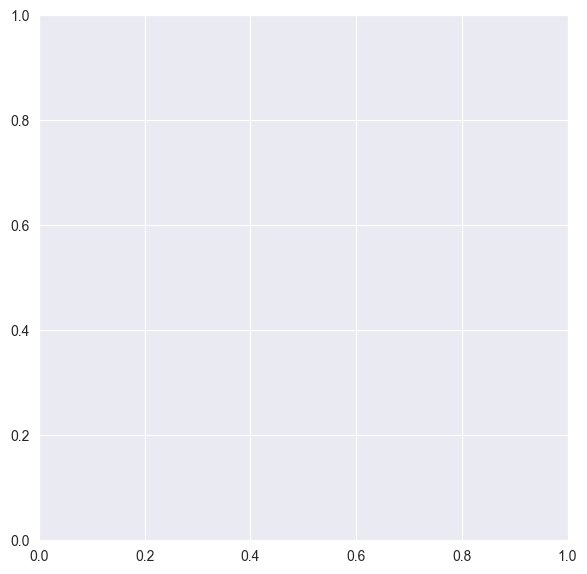

In [69]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()